# Environment Setup

In [ ]:
!pip3 install gym
!pip3 install stable-baselines3[extra]
!pip3 install 'shimmy>=2.0'
!pip3 install pandas
!pip3 install pybullet

## Gym Class

In [1]:
import gym
from gym import spaces
import numpy as np
import pybullet as p
import pybullet_data
import cv2
import math
import time
import random


class PandaTennisEnv(gym.Env):
    def __init__(self, enable_gui = True):
        super(PandaTennisEnv, self).__init__()
        
        # preset parameters
        self.time_step = 1.0 / 240.0
        self.wait_period = 40 # How long should the system rest to adjust joints
        self.step_number = 0 # step number count starts from 0
        
        # RGB Camera parameters
        self.camera_width = 640
        self.camera_height = 480
        self.fov = 60  # Field of view in degrees
        self.aspect = self.camera_width / self.camera_height
        self.near = 0.01
        self.far = 100
        self.cam_pos = [-1.5, 0, 1.5]  # Camera position
        self.target = [0, 0, 1.5]  # Look-at point
        self.up_vector = [0, 0, 1]  # Up direction
        self.enable_camera = False
        self.enable_opencv_window = False
        
        # Environmental Factors
        self.gravitational_acceleration = 9.802 # m/s^2 (actual value of g in new york city: https://physicslabs.ccnysites.cuny.edu/labs/207/207-little-g/littleg.php#:~:text=In%20fact%20in%20New%20York,of%20the%20North%2DEast%20US. )
        self.lateral_friction = 0.2 ## Table has separate parameters
        self.spinning_friction = 0.05
        self.rolling_friction = 0.05
        self.restitution = 0.9
        self.air_resistance_coefficient = 0.001

        # Terrain properties
        self.ground_texture = 'green-terrain.png'
        self.terrain_size = 256  # Number of grid points per side
        self.terrain_scale = 0.5  # Horizontal scaling
        self.terrain_height_scale = 0.1  # Maximum height of terrain

        # Panda Parameters
        self.panda_preset_position = [0, 0, 0, 0, 0, 2.258, 0.437]

        # Husky Parameters
        self.husky_init_pos = [-1.0, 0, 0]
        self.enable_husky_movement = False # This fixes the husky base with ground disabling husky control
        
        # ball properties
        self.ball_radius = 0.0335  # Radius (6.7 cm diameter / 2)
        self.ball_mass = 0.058  # Standard tennis ball mass in kg
        self.ball_color = [1, 1, 0, 1]
        self.ball_position = [3.5, 0.0, 1.5]  # Initial position of the ball
        self.ball_initial_vel = [0, 0, 3]
        self.ball_initial_angular_vel = [0, 0, 0] # this is the spin
        
        # Wall properties
        self.wall_size = [0.55, 1.5, 1.0]  # [length, thickness, height]
        self.wall_mass = 2000  # Static wall
        self.wall_color = [0.5, 0.5, 0.5, 1]
        self.wall_position = [5, 0.0, 0.0]  # Adjust the position as needed
        self.wall_orientation = p.getQuaternionFromEuler([0, 0, 0])  # No rotation

        # Table dimensions and properties
        self.table_length = 2.74  # meters
        self.table_width = 1.525  # meters
        self.table_height = 0.76  # meters
        self.table_position = [2, 0, self.table_height / 2]  # Move table to (2, 0)
        self.table_restitution = 0.9
        self.table_lateral_friction = 0.2
        self.table_spinning_friction = 0.05
        self.table_rolling_friction = 0.05
     
        # Define observation and action spaces
        husky_low = np.array([-5, -5, -5, -5], dtype=np.float32)  # Husky wheels: -5 to +5
        husky_high = np.array([5, 5, 5, 5], dtype=np.float32)
        panda_low = np.radians([-180]*7)  # Panda joints: -180 degrees
        panda_high = np.radians([180]*7)  # Panda joints: +180 degrees
        low = np.concatenate([panda_low, husky_low])
        high = np.concatenate([panda_high, husky_high])
        self.action_space = spaces.Box(low=low, high=high, dtype=np.float32)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(49,), dtype=np.float32)

        # Connect to PyBullet in GUI mode
        self.physics_client = p.connect(p.GUI if enable_gui else p.DIRECT)
        p.setAdditionalSearchPath(pybullet_data.getDataPath())
        self.initialize_everything()
        
        

    def initialize_everything(self):
        p.setTimeStep(self.time_step)
        p.setGravity(0,0,-self.gravitational_acceleration)
        self.step_number = 0
        
        # self.plane_id = p.loadURDF("plane.urdf")
        # Generate heightfield data (random uneven surface)
        heightfield_data = np.random.uniform(low=-1, high=1, size=(self.terrain_size, self.terrain_size))
        heightfield_data = (heightfield_data - heightfield_data.min()) / (heightfield_data.max() - heightfield_data.min())
        heightfield_data *= self.terrain_height_scale  # Scale heights
        
        # Flatten the heightfield for PyBullet
        heightfield_data = heightfield_data.flatten()
        
        # Create the heightfield shape
        terrain_shape = p.createCollisionShape(
            shapeType=p.GEOM_HEIGHTFIELD,
            meshScale=[self.terrain_scale, self.terrain_scale, 1],
            heightfieldTextureScaling=(self.terrain_size - 1) / 2,
            heightfieldData=heightfield_data,
            numHeightfieldRows=self.terrain_size,
            numHeightfieldColumns=self.terrain_size,
        )
        
        # Create the terrain body
        self.plane_id = p.createMultiBody(0, terrain_shape)
        
        # Apply a texture to the uneven plane
        texture_id = p.loadTexture(self.ground_texture)  # Use a texture from PyBullet's data
        p.changeVisualShape(self.plane_id, -1, textureUniqueId=texture_id)
        if self.enable_husky_movement:
            self.husky_id = p.loadURDF("husky/husky.urdf", self.husky_init_pos) # allows husky to move
        else:
            self.husky_id = p.loadURDF("husky/husky.urdf", self.husky_init_pos, useFixedBase = True) # disables husky movement
            
        self.panda_id = p.loadURDF("franka_panda_mod/panda.urdf", [0.2, 0, 0.30])
        self.bat_id = p.loadURDF("Squash.urdf", basePosition=[0, 0, 0.8], baseOrientation = p.getQuaternionFromEuler([0, 0, 0]))  # Replace with the actual path to the URDF

        ## Build Wall
        # self.build_wall()
        
        self.mount_bodies()
        p.changeDynamics(self.bat_id, -1, 
                         restitution=self.restitution, 
                         lateralFriction=self.lateral_friction, 
                         spinningFriction = self.spinning_friction, 
                         rollingFriction = self.rolling_friction,
                        )
        
        p.changeDynamics(bodyUniqueId=self.plane_id, linkIndex=-1,
                         restitution=self.restitution, 
                         lateralFriction=self.lateral_friction, 
                         spinningFriction = self.spinning_friction, 
                         rollingFriction = self.rolling_friction,
                        )
        
        # Apply dynamics properties to all links of panda
        num_joints = p.getNumJoints(self.panda_id)
        for link_index in range(-1, num_joints):  # -1 refers to the base link
            p.changeDynamics(self.panda_id, link_index, 
                             restitution=self.restitution, 
                             lateralFriction=self.lateral_friction,
                             spinningFriction = self.spinning_friction, 
                             rollingFriction = self.rolling_friction,
                            )

        # Apply damping for all joints
        for joint_index in range(num_joints):
            p.changeDynamics(self.panda_id, joint_index, 
                             linearDamping=0.04, 
                             angularDamping=0.04)

        self.get_new_ball(self.ball_position)
        self.throw_ball(self.ball_initial_vel, self.ball_initial_angular_vel)

        ## build table
        self.build_table()

    def build_wall(self):
        # Create wall collision shape
        wall_collision = p.createCollisionShape(p.GEOM_BOX, halfExtents=self.wall_size)
        # Create wall visual shape
        wall_visual = p.createVisualShape(p.GEOM_BOX, halfExtents=self.wall_size, rgbaColor=self.wall_color)  # Grey color
        # Create the wall body
        self.wall_id = p.createMultiBody(
            baseMass=self.wall_mass,
            baseCollisionShapeIndex=wall_collision,
            baseVisualShapeIndex=wall_visual,
            basePosition=self.wall_position,
            baseOrientation=self.wall_orientation
        )
        p.changeDynamics(self.wall_id, -1, lateralFriction=self.lateral_friction, restitution=self.restitution)



    def build_table(self):
        # Create the table as a box
        table_visual = p.createVisualShape(
            shapeType=p.GEOM_BOX,
            halfExtents=[self.table_length / 2, self.table_width / 2, self.table_height / 2],
            rgbaColor=[0, 0.6, 0, 1],  # Dark green color for the table
        )
        
        table_collision = p.createCollisionShape(
            shapeType=p.GEOM_BOX,
            halfExtents=[self.table_length / 2, self.table_width / 2, self.table_height / 2],
        )
        
        self.table_id = p.createMultiBody(
            baseMass=0,
            baseCollisionShapeIndex=table_collision,
            baseVisualShapeIndex=table_visual,
            basePosition=self.table_position,
        )
        
        # Set the physical properties of the table
        p.changeDynamics(self.table_id, -1, 
                         restitution=self.table_restitution, 
                         lateralFriction=self.table_lateral_friction, 
                         spinningFriction = self.table_spinning_friction, 
                         rollingFriction = self.table_rolling_friction,
                        )
        
        # Draw the court lines
        line_color = [1, 1, 1, 1]  # White color for the lines
        
        # Outer border (2 cm width)
        p.addUserDebugLine(
            lineFromXYZ=[self.table_position[0] - self.table_length / 2, self.table_position[1] - self.table_width / 2, self.table_height],
            lineToXYZ=[self.table_position[0] - self.table_length / 2, self.table_position[1] + self.table_width / 2, self.table_height],
            lineColorRGB=line_color,
            lineWidth=4,
        )
        p.addUserDebugLine(
            lineFromXYZ=[self.table_position[0] - self.table_length / 2, self.table_position[1] + self.table_width / 2, self.table_height],
            lineToXYZ=[self.table_position[0] + self.table_length / 2, self.table_position[1] + self.table_width / 2, self.table_height],
            lineColorRGB=line_color,
            lineWidth=4,
        )
        p.addUserDebugLine(
            lineFromXYZ=[self.table_position[0] + self.table_length / 2, self.table_position[1] + self.table_width / 2, self.table_height],
            lineToXYZ=[self.table_position[0] + self.table_length / 2, self.table_position[1] - self.table_width / 2, self.table_height],
            lineColorRGB=line_color,
            lineWidth=4,
        )
        p.addUserDebugLine(
            lineFromXYZ=[self.table_position[0] + self.table_length / 2, self.table_position[1] - self.table_width / 2, self.table_height],
            lineToXYZ=[self.table_position[0] - self.table_length / 2, self.table_position[1] - self.table_width / 2, self.table_height],
            lineColorRGB=line_color,
            lineWidth=4,
        )
        
        # Centerline (3 mm width)
        p.addUserDebugLine(
            lineFromXYZ=[self.table_position[0], self.table_position[1] - self.table_width / 2, self.table_height],
            lineToXYZ=[self.table_position[0], self.table_position[1] + self.table_width / 2, self.table_height],
            lineColorRGB=line_color,
            lineWidth=4,
        )
        
        p.addUserDebugLine(
            lineFromXYZ=[self.table_position[0] - self.table_length / 2, self.table_position[1], self.table_height],
            lineToXYZ=[self.table_position[0] + self.table_length / 2, self.table_position[1], self.table_height],
            lineColorRGB=line_color,
            lineWidth=4,
        )

    def apply_air_resistance(self):
        velocity, angular_velocity = p.getBaseVelocity(self.ball_id)
        # Calculate air resistance (linear and angular)
        air_resistance_force = [-self.air_resistance_coefficient * v for v in velocity]
        air_resistance_torque = [-self.air_resistance_coefficient * av for av in angular_velocity]
        
        # Apply forces and torques
        p.applyExternalForce(self.ball_id, -1, air_resistance_force, [0, 0, 0], p.WORLD_FRAME)
        p.applyExternalTorque(self.ball_id, -1, air_resistance_torque, p.WORLD_FRAME)
        
    
    def mount_bodies(self):
        # mount the panda on the husky
        husky_chassis_link_index = 0  # chasis link index
        
        # Create the fixed constraint
        self.husky_panda_mount = p.createConstraint(
            parentBodyUniqueId=self.husky_id,
            parentLinkIndex=husky_chassis_link_index,
            childBodyUniqueId=self.panda_id,
            childLinkIndex=-1,  # -1 means the base link of the child
            jointType=p.JOINT_FIXED,
            jointAxis=[0, 0, 0],
            parentFramePosition=[0.3, 0, 0.25],  # Offset on Husky where the Panda arm will be attached
            childFramePosition=[0, 0, 0]  # Offset on Panda where it attaches to Husky
        )

        # set panda to preset position
        for joint_index, target_position in zip(range(0, 7), self.panda_preset_position):
            p.setJointMotorControl2(
                bodyUniqueId=self.panda_id,
                jointIndex=joint_index,
                controlMode=p.POSITION_CONTROL,
                targetPosition=target_position,
                force=500  # Adjust max torque/force as needed
            )

        for i in range (self.wait_period):
            p.stepSimulation()
        # panda_bat_mount
        end_effector_index = 7  # Replace with your actual end effector index
        
        # Position and orientation offsets to align the tennis bat with the end effector
        offset_position = [0, 0, 0.25]  # Adjust based on your setup
        offset_orientation = p.getQuaternionFromEuler([0, 0, 0])  # Adjust if needed
        
        # Create a fixed constraint
        self.panda_bat_mount = p.createConstraint(
            parentBodyUniqueId=self.panda_id,
            parentLinkIndex=end_effector_index,
            childBodyUniqueId=self.bat_id,
            childLinkIndex=-1,  # Base of the tennis bat
            jointType=p.JOINT_FIXED,
            jointAxis=[0, 0, 0],
            parentFramePosition=offset_position,
            parentFrameOrientation=offset_orientation,
            childFramePosition=[0, 0, 0],
            childFrameOrientation=[0, 0, 0]
        )
        for i in range (self.wait_period):
            p.stepSimulation()



    def get_camera_feed(self):
        # Compute view and projection matrices
        view_matrix = p.computeViewMatrix(self.cam_pos, self.target, self.up_vector)
        proj_matrix = p.computeProjectionMatrixFOV(self.fov, self.aspect, self.near, self.far)
        
        # Capture the image
        _, _, rgb_img, _, _ = p.getCameraImage(self.camera_width, 
                                               self.camera_height, 
                                               view_matrix, 
                                               proj_matrix, 
                                               # renderer=p.ER_BULLET_HARDWARE_OPENGL,
                                              )
        rgb_img = np.array(rgb_img, dtype=np.uint8).reshape((self.camera_height, self.camera_width, 4))
        if self.enable_opencv_window:
            cv2.imshow("RGB Camera", rgb_img[:, :, :3])  # Ignore alpha channel
            if cv2.waitKey(1) != -1:  # If any key is pressed, exit 
                cv2.destroyAllWindows()
                self.enable_opencv_window = False
        return rgb_img


    
    def reset(self):
        # Reset simulation
        p.resetSimulation()
        p.removeAllUserDebugItems()
        self.initialize_everything()
        return self._get_observation()
    
    def _get_observation(self):

        # ball states
        ball_pos, ball_orn = p.getBasePositionAndOrientation(self.ball_id)
        ball_linear_velocity, ball_angular_velocity = p.getBaseVelocity(self.ball_id) # Ignore angular velocity. Difficult to estimate in reality
        

        # bat states
        bat_pos, bat_orn = p.getBasePositionAndOrientation(self.bat_id)
        bat_dynamics_info = p.getDynamicsInfo(self.bat_id, -1)
        bat_com_offset = bat_dynamics_info[3]  # Local COM position
        bat_com_global = p.multiplyTransforms(bat_pos, bat_orn, bat_com_offset, [0, 0, 0, 1])[0] # Global COM position


        # Husky states
        husky_pos, husky_orn = p.getBasePositionAndOrientation(self.husky_id)
        husky_lin_vel, husky_ang_vel = p.getBaseVelocity(self.husky_id)
        
        

        # Panda states
        panda_num_joints = p.getNumJoints(self.panda_id)
        panda_joint_states = p.getJointStates(self.panda_id, range(panda_num_joints))
        panda_joint_pos = [state[0] for state in panda_joint_states]
        panda_joint_vel = [state[1] for state in panda_joint_states]
        
        system_state = np.concatenate([
                np.array(ball_pos),                 # 3 values: Ball position
                np.array(ball_orn),                # 4 values: Ball orientation
                np.array(ball_linear_velocity),    # 3 values: Ball linear velocity
                np.array(bat_pos),                 # 3 values: Bat position
                np.array(bat_orn),                 # 4 values: Bat orientation
                np.array(bat_com_global),          # 3 values: Bat COM global position
                np.array(husky_pos),               # 3 values: Husky position
                np.array(husky_orn),               # 4 values: Husky orientation
                np.array(husky_lin_vel),           # 3 values: Husky linear velocity
                np.array(husky_ang_vel),           # 3 values: Husky angular velocity
                np.array(panda_joint_pos),         # 7 values: Panda joint positions
                np.array(panda_joint_vel)          # 7 values: Panda joint velocities
            ])
        return system_state


    def get_new_ball(self, initial_position):
        # Create ball collision shape
        ball_collision = p.createCollisionShape(p.GEOM_SPHERE, radius=self.ball_radius)
        # Create ball visual shape
        ball_visual = p.createVisualShape(p.GEOM_SPHERE, radius=self.ball_radius, rgbaColor=self.ball_color)  # Yellow color
        # Create the ball body
        self.ball_id = p.createMultiBody(
            baseMass=self.ball_mass,
            baseCollisionShapeIndex=ball_collision,
            baseVisualShapeIndex=ball_visual,
            basePosition=initial_position,
        )
        p.changeDynamics(self.ball_id, -1, lateralFriction=self.lateral_friction, restitution=self.restitution)

    def set_ball_init_position(self, initial_position):
        p.resetBasePositionAndOrientation(self.ball_id, initial_position, [0, 0, 0, 1])
    
    # Function to draw the COM of bat and axes
    def visualize_com(self):
        # Function to rotate a vector by a quaternion
        def rotate_vector(vector, quaternion):
            return p.multiplyTransforms([0, 0, 0], quaternion, vector, [0, 0, 0, 1])[0]
        
        # Get COM for the base link
        dynamics_info = p.getDynamicsInfo(self.bat_id, -1)
        com_offset = dynamics_info[3]  # Local COM position
        base_pos, base_orn = p.getBasePositionAndOrientation(self.bat_id)
        
        # Transform the local COM to global coordinates
        com_global = p.multiplyTransforms(base_pos, base_orn, com_offset, [0, 0, 0, 1])[0]
        
        # Define local unit axes
        axis_length = 0.2  # Length of the axes
        x_axis = [axis_length, 0, 0]
        y_axis = [0, axis_length, 0]
        z_axis = [0, 0, axis_length]
        
        # Rotate local axes to match the base's orientation
        x_axis_global = rotate_vector(x_axis, base_orn)
        y_axis_global = rotate_vector(y_axis, base_orn)
        z_axis_global = rotate_vector(z_axis, base_orn)
        
        # Compute global endpoints of the axes
        x_end = [com_global[i] + x_axis_global[i] for i in range(3)]
        y_end = [com_global[i] + y_axis_global[i] for i in range(3)]
        z_end = [com_global[i] + z_axis_global[i] for i in range(3)]
        
        # Draw lines for the axes
        p.addUserDebugLine(com_global, x_end, [1, 0, 0], 3)  # Red for X-axis
        p.addUserDebugLine(com_global, y_end, [0, 1, 0], 3)  # Green for Y-axis
        p.addUserDebugLine(com_global, z_end, [0, 0, 1], 3)  # Blue for Z-axis
        

    # remove all the lines or user debug texts added
    def removeUserDebugItems(self):
        p.removeAllUserDebugItems()

    
    def throw_ball(self, initial_velocity, angular_velocity = [0, 0, 0]):
        # Throw the ball with initial velocity
        # initial_velocity = [3, 0, 2]  # Velocity in x, y, z directions
        p.resetBaseVelocity(self.ball_id, linearVelocity=initial_velocity, angularVelocity = angular_velocity)


    def get_desired_panda_end_effector_pos_orn(self, desired_bat_com_position, desired_bat_com_orientation):
        bat_pos, bat_orn = p.getBasePositionAndOrientation(self.bat_id)
        bat_dynamics_info = p.getDynamicsInfo(self.bat_id, -1)
        bat_com_offset = bat_dynamics_info[3]  # Local COM position
        desired_bat_com_orientation = p.getQuaternionFromEuler(desired_bat_com_orientation)
        com_offset_transformed = p.multiplyTransforms([0, 0, 0], desired_bat_com_orientation, bat_com_offset, [0, 0, 0, 1])[0]
        
        # Step 2: Calculate the desired end-effector position
        desired_end_effector_position = [desired_bat_com_position[0] - com_offset_transformed[0],
                                          desired_bat_com_position[1] - com_offset_transformed[1],
                                          desired_bat_com_position[2] - com_offset_transformed[2]]
        desired_end_effector_orientation = desired_bat_com_orientation
        return desired_end_effector_position, desired_end_effector_orientation


    def panda_IK(self, desired_bat_com_position, desired_bat_com_orientation):
        end_effector_index = 6
        desired_end_effector_position, desired_end_effector_orientation = self.get_desired_panda_end_effector_pos_orn(desired_bat_com_position, desired_bat_com_orientation)
        joint_angles = p.calculateInverseKinematics(end.panda_id, end_effector_index, desired_end_effector_position, desired_end_effector_orientation)
        return joint_angles

    def step(self, action):
        self.apply_air_resistance()
        self.step_number += 1
        panda_actions = action[:7]  # First 7 values for Panda arm
        husky_actions = action[7:]  # Last 4 values for Husky wheels


         # Apply actions to Husky wheels
        panda_joints = [0, 1, 2, 3, 4, 5, 6]  # Joint indices for the Husky wheels
        for i, act in enumerate(panda_actions):
            p.setJointMotorControl2(
                self.panda_id,
                panda_joints[i],
                p.VELOCITY_CONTROL,
                targetVelocity=act  # Use velocity directly within [-5, 5]
            )


        
        
        # Apply actions to Husky wheels
        wheel_joints = [2, 3, 4, 5]  # Joint indices for the Husky wheels
        for i, act in enumerate(husky_actions):
            p.setJointMotorControl2(
                self.husky_id,
                wheel_joints[i],
                p.VELOCITY_CONTROL,
                targetVelocity=act  # Use velocity directly within [-5, 5]
            )
    
        # Step the simulation
        p.stepSimulation()
        if self.enable_camera:
            self.get_camera_feed()
    
        # Calculate reward and check if done
        reward = self._calculate_reward()
        done = self._check_done()

        ## Enable markers
        # self.visualize_com()
        # self.removeUserDebugItems()
        return self._get_observation(), reward, done, {}

    def ball_is_approaching(self):
        """
        Determine if a moving ball is approaching a point in 3D space.
    
        Parameters:
            ball_position (np.ndarray): The current position of the ball as a 3D vector (x, y, z).
            ball_velocity (np.ndarray): The velocity of the ball as a 3D vector (vx, vy, vz).
            target_point (np.ndarray): The target point in space as a 3D vector (px, py, pz).
    
        Returns:
            bool: True if the ball is approaching the target point, False otherwise.
        """
        ball_position, _ = p.getBasePositionAndOrientation(self.ball_id)
        ball_velocity, _ = p.getBaseVelocity(self.ball_id) # Ignore angular velocity. Difficult to estimate in reality
        bat_pos, bat_orn = p.getBasePositionAndOrientation(self.bat_id)
        bat_dynamics_info = p.getDynamicsInfo(self.bat_id, -1)
        bat_com_offset = bat_dynamics_info[3]  # Local COM position
        bat_com_global = p.multiplyTransforms(bat_pos, bat_orn, bat_com_offset, [0, 0, 0, 1])[0] # Global COM position
        target_point = bat_com_global
        # Calculate the relative position vector from the ball to the target
        relative_position = np.array(target_point) - np.array(ball_position)
        
        # Calculate the dot product of the relative position and velocity
        dot_product = np.dot(relative_position, ball_velocity)
        
        # If the dot product is negative, the ball is approaching the target point
        return dot_product < 0

    
    def _calculate_reward(self):
        total_reward = 0
    
        # Get Husky's current state
        husky_pos, husky_orn = p.getBasePositionAndOrientation(self.husky_id)
        husky_lin_vel, husky_ang_vel = p.getBaseVelocity(self.husky_id)
        
        # Husky Stability: penalize if husky is too tilted
        husky_pitch = np.arctan2(2 * (husky_orn[3] * husky_orn[0] + husky_orn[0] * husky_orn[1]),
                                 1 - 2 * (husky_orn[0]**2 + husky_orn[1]**2))
        husky_roll = np.arctan2(2 * (husky_orn[3] * husky_orn[1] + husky_orn[2] * husky_orn[0]),
                                1 - 2 * (husky_orn[1]**2 + husky_orn[2]**2))
        
        # Stability reward: higher penalty for larger tilt
        stability_penalty = np.clip(np.abs(husky_pitch) + np.abs(husky_roll), 0, 1)
        total_reward -= 0.5 * stability_penalty  # negative reward for instability
        
        # Panda Arm: track bat's position and orientation
        bat_pos, bat_orn = p.getBasePositionAndOrientation(self.bat_id)
        bat_dynamics_info = p.getDynamicsInfo(self.bat_id, -1)
        bat_com_offset = bat_dynamics_info[3]  # Local COM position
        bat_com_global = p.multiplyTransforms(bat_pos, bat_orn, bat_com_offset, [0, 0, 0, 1])[0]
        
        # Ball: get position and velocity of the ball
        ball_pos, ball_orn = p.getBasePositionAndOrientation(self.ball_id)
        ball_linear_velocity, _ = p.getBaseVelocity(self.ball_id)
        
        # Reward for the ball approaching the bat
        approaching_reward = 0
        if self.ball_is_approaching():
            approaching_reward = 10  # Reward when the ball is approaching the bat
        
        # Reward for successful hit (after intercepting)
        hit_reward = 0
        if np.linalg.norm(ball_linear_velocity) > 0 and ball_pos[2] > 0:  # Ball is hit and moving upwards
            hit_reward = 1  # Reward for hitting the ball upwards
        
        # Reward for bat position matching the ideal position to hit the ball
        bat_to_ball_dist = np.linalg.norm(np.array(ball_pos) - np.array(bat_com_global))
        bat_orientation_diff = np.linalg.norm(np.array(bat_orn) - np.array(ball_orn))  # You may calculate ideal bat orientation for hitting
    
        intercept_reward = -bat_to_ball_dist - bat_orientation_diff  # Reward for positioning bat for intercepting ball
        total_reward += 0.5 * intercept_reward + 0.5 * hit_reward + 0.5 * approaching_reward + 0.05*self.step_number # Adding rewards for interception, hit, and approach
        
        # Add more reward for consecutive hits (optional)
        consecutive_hits_reward = 0  # Could track in the class if the robot hits the ball multiple times in a row
        total_reward += consecutive_hits_reward
        return total_reward
    
    def _check_done(self):
        # Get the position of the ball
        ball_pos, ball_orn = p.getBasePositionAndOrientation(self.ball_id)
        
        # Get the vertical velocity of the ball (in the z direction)
        ball_linear_velocity, ball_angular_velocity = p.getBaseVelocity(self.ball_id)
        ball_vertical_velocity = ball_linear_velocity[2]  # The z component of velocity
        
        # Done condition: Ball hits the ground (z position below a threshold or vertical velocity down)
        if ball_pos[2] < 0.1:
            # Ball has hit the ground, episode should end
            return True
        
        return False
    
    def render(self, mode="human"):
        pass  # PyBullet GUI provides rendering
    
    def close(self):
        p.disconnect()


pybullet build time: Jan 31 2025 10:33:19


## Start the sim

In [2]:
# Test the model
env = PandaTennisEnv(enable_gui = True)

/Users/sakibchowdhury/Library/Mobile Documents/com~apple~CloudDocs/WorkingDirectory/Academic/PhD_Stevens/semester_5/bullet-husky-panda/env/lib/python3.13/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
2025-02-03 13:10:46.866 Python[10602:505846] +[IMKClient subclass]: chose IMKClient_Modern
2025-02-03 13:10:46.866 Python[10602:505846] +[IMKInputSession subclass]: chose IMKInputSession_Modern


## Test Run

In [5]:
# Load the trained model
# model = PPO.load("panda_tennis_model")

# Test the model
# env = PandaTennisEnv()

obs = env.reset()
env.set_ball_init_position([1, 0, 2])
env.throw_ball([1, 0, 2], [3, 0, 0])
for i in range(100000):
    # panda_action = [-0.066, -1.925, -0.033, -2.016, 0.099, 1.858, 1.818] # joint position
    panda_action = [0]*7 # panda_velocities
    husky_action = [0]*4 # wheel velocity
    action = panda_action + husky_action
    obs, reward, done, info = env.step(action)
    # print(obs)
    time.sleep(1/240)
    # env.get_new_ball([0, 0, 2])
    # env.throw_ball([0, 1, 1])
    # p.stepSimulation()
    # husky_position, husky_orientation = p.getBasePositionAndOrientation(env.husky_id)
    # print(husky_position, husky_orientation)
    
    # if done:
    #     obs = env.reset()


KeyboardInterrupt: 

## Enable Sliders for Panda Joint Control

In [4]:
# Get joint information
num_joints = p.getNumJoints(env.panda_id)
joint_indices = [i for i in range(num_joints) if p.getJointInfo(env.panda_id, i)[2] == p.JOINT_REVOLUTE]

# Create sliders for each joint
sliders = {}
for joint_index in joint_indices:
    joint_info = p.getJointInfo(env.panda_id, joint_index)
    joint_name = joint_info[1].decode("utf-8")
    joint_limit_low = joint_info[8]
    joint_limit_high = joint_info[9]
    slider = p.addUserDebugParameter(joint_name, joint_limit_low, joint_limit_high, 0.0)
    sliders[joint_index] = slider

# Simulation loop
while True:
    # Read slider values and control joints
    for joint_index, slider in sliders.items():
        slider_value = p.readUserDebugParameter(slider)
        p.setJointMotorControl2(
            bodyUniqueId=env.panda_id,
            jointIndex=joint_index,
            controlMode=p.POSITION_CONTROL,
            targetPosition=slider_value,
            force=500  # Set maximum torque/force
        )
    
    # Step the simulation
    panda_action = [0]*7 # panda_velocities
    husky_action = [0]*4 # wheel velocity
    action = panda_action + husky_action
    # obs, reward, done, info = env.step(action)
    p.stepSimulation()
    time.sleep(0.01)  # Add a small delay for stability

error: Failed to read parameter.

## Make Panda Dance (don't use - panda uses velocity control now)

In [ ]:
# Get number of joints
num_joints = p.getNumJoints(env.panda_id)

# Define the range of motion for the joints
joint_ranges = {
    0: (-2.9, 2.9),
    1: (-1.76, 1.76),
    2: (-2.9, 2.9),
    3: (-3.07, -0.07),
    4: (-2.9, 2.9),
    5: (-0.017, 3.75),
    6: (-2.9, 2.9),
}

# Simulation parameters
duration = 100  # Total time for the dance (seconds)
frequency = 0.05  # Frequency of oscillation (Hz)

# Create a time-based loop
start_time = time.time()
while time.time() - start_time < duration:
    current_time = time.time() - start_time

    # Set joint positions in a sinusoidal pattern
    for joint_index in range(7):  # Panda has 7 controllable joints
        joint_range = joint_ranges[joint_index]
        joint_center = (joint_range[0] + joint_range[1]) / 2
        joint_amplitude = (joint_range[1] - joint_range[0]) / 4

        # Calculate target position using a sine wave
        target_position = joint_center + joint_amplitude * np.sin(2 * np.pi * frequency * current_time + joint_index)

        # Set joint position
        p.setJointMotorControl2(
            bodyUniqueId=env.panda_id,
            jointIndex=joint_index,
            controlMode=p.POSITION_CONTROL,
            targetPosition=target_position,
        )
    # Clear previous lines
    env.removeUserDebugItems()
    
    # Visualize the COM of the bat
    env.visualize_com()
    print(env._get_observation())

    # Step simulation
    p.stepSimulation()
    time.sleep(1 / 240)  # Match the simulation timestep (240 Hz)

In [ ]:
pybullet_data.getDataPath()

In [ ]:
# Test the model
env = PandaTennisEnv(enable_gui = True)

In [ ]:
while True:
    # panda_action = [-0.066, -1.925, -0.033, -2.016, 0.099, 1.858, 1.818] # joint position
    panda_action = [0.0]*7 # panda_velocities
    husky_action = [-1]*4 # wheel velocity
    action = panda_action + husky_action
    obs, reward, done, info = env.step(action)
    # print(obs)
    time.sleep(1/240)
    # husky_position, husky_orientation = p.getBasePositionAndOrientation(env.husky_id)
    # print(husky_position, husky_orientation)
    # Extract velocities
    joint_states = p.getJointStates(
        bodyUniqueId=env.panda_id,
        jointIndices=range(7)
    )

    velocities = [joint_state[1] for joint_state in joint_states]
    print(f"Joint Velocities: {velocities}")
    p.stepSimulation()

# Integrate Physics

## Estimate Initial Velocity

In [3]:

def estimate_initial_velocity(pos1, pos2, delta_t):
    """
    Estimate the initial velocity of a ball given two consecutive positions.

    Args:
    - pos1 (list or np.array): First position [x1, y1, z1].
    - pos2 (list or np.array): Second position [x2, y2, z2].
    - delta_t (float): Time interval between the two positions.

    Returns:
    - velocity (np.array): Estimated velocity [vx, vy, vz].
    """
    pos1 = np.array(pos1)
    pos2 = np.array(pos2)

    # Compute velocity
    velocity = (pos2 - pos1) / delta_t

    return velocity

## Finding Bounce and hitting Point

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def get_bounce_position_and_hit_position(initial_position, # for the ball 
                                         initial_velocity, # for the ball
                                         table_height, 
                                         coeff_restitution, 
                                         x_a, # x = a plane position (provide the value of a)
                                         g,
                                        ):
    # Compute bounce time
    t_bounce = (initial_velocity[2] + np.sqrt(initial_velocity[2]**2 + 2 * g * (initial_position[2] - table_height))) / g
    bounce_position = initial_position + initial_velocity * t_bounce - 0.5 * np.array([0, 0, g]) * t_bounce**2
    bounce_velocity = np.array([initial_velocity[0], initial_velocity[1], -coeff_restitution * (initial_velocity[2] - g * t_bounce)])
    
    # Compute time to reach x = a after bounce
    t_hit = (x_a - bounce_position[0]) / bounce_velocity[0]
    hit_position = bounce_position + bounce_velocity * t_hit - 0.5 * np.array([0, 0, g]) * t_hit**2
    return bounce_position, bounce_velocity, hit_position, t_bounce, t_hit 



## Draw the x = a plane

In [6]:
def draw_xa_plane(x_a):
    # Define grid size
    y_min, y_max = -1.5, 1.5
    z_min, z_max = 0, 2
    num_lines = 1  # Increase for finer grid
    
    for i in range(num_lines + 1):
        y = y_min + i * (y_max - y_min) / num_lines
        z = z_min + i * (z_max - z_min) / num_lines
        
        # Vertical grid lines
        p.addUserDebugLine([x_a, y_min, z], [x_a, y_max, z], [0, 1, 0])
        # Horizontal grid lines
        p.addUserDebugLine([x_a, y, z_min], [x_a, y, z_max], [0, 1, 0])
        # 

## Set ball initial position and velocity randomly

In [13]:
def set_random_ball_conditions(ball_id):
    """Sets a random initial position and velocity ensuring the ball bounces on the table once and reaches x = a"""
    TABLE_HEIGHT = env.table_height  # Typical table tennis table height in meters
    GRAVITY = 9.81  # Gravity in m/s^2
    RESTITUTION = 0.9  # Coefficient of restitution (bounciness)
    X_TARGET = -0.2  # The x = a plane where the ball should reach after one bounce
    Vx_ADJUST = 0.8 # add a slightly more Vx 

    # Choose a random initial position (starting on one side of the table)
    x0 = np.random.uniform(3.5, 4.5)  # Start from left side of the table
    y0 = np.random.uniform(-0.5, 0.5)  # Random lateral position
    z0 = np.random.uniform(TABLE_HEIGHT + 0.1, TABLE_HEIGHT + 0.3)  # Above the table

    # Choose a valid initial vertical velocity to ensure it lands on the table
    vz0 = np.random.uniform(3.0, 7.0)  # Positive upwards velocity

    # Compute time to bounce
    tb = (vz0 + np.sqrt(vz0**2 + 2 * GRAVITY * (z0 - TABLE_HEIGHT))) / GRAVITY

    # Compute velocity after bounce
    vz_after_bounce = -RESTITUTION * vz0

    # Compute required x velocity to reach x = a
    tf = abs(vz_after_bounce) / GRAVITY * 2  # Approximate time after bounce
    vx0 = ((X_TARGET - x0) / (tb + tf)) - Vx_ADJUST  # Solve for vx0

    # Random y velocity (ensure it stays on table)
    vy0 = np.random.uniform(-0.5, 0.5)

    # Set ball position and velocity in PyBullet
    env.set_ball_init_position([x0, y0, z0])
    env.throw_ball([vx0, vy0, vz0])

    # print(f"Set initial position: {x0:.3f}, {y0:.3f}, {z0:.3f}")
    # print(f"Set initial velocity: {vx0:.3f}, {vy0:.3f}, {vz0:.3f}")

## Write the results in a CSV file

In [8]:
import csv

# Define the CSV file name
csv_filename = "ball_trajectory_data.csv"

# Define the header for the CSV file
csv_header = ["initial_x", "initial_y", "initial_z", 
              "initial_vx", "initial_vy", "initial_vz",
              "distance_to_x_a", "estimated_hit_x", "estimated_hit_y", "estimated_hit_z",
              "real_hit_x", "real_hit_y", "real_hit_z",
              "delta_x", "delta_y", "delta_z",]

# Function to write data to CSV
def write_to_csv(initial_pos, initial_vel, distance_to_x_a, estimated_hit, real_hit, delta):
    """Writes trajectory data to a CSV file."""
    data = [
        initial_pos[0], initial_pos[1], initial_pos[2], 
        initial_vel[0], initial_vel[1], initial_vel[2], 
        distance_to_x_a, estimated_hit[0], estimated_hit[1], estimated_hit[2],
        real_hit[0], real_hit[1], real_hit[2], 
        delta[0], delta[1], delta[2]
    ]

    # Check if the file exists and write the header only once
    try:
        with open(csv_filename, mode='x', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(csv_header)  # Write header
            writer.writerow(data)
    except FileExistsError:
        with open(csv_filename, mode='a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(data)


## Test Run 

Predicted Bounce Position: [ 1.5948075  -0.26792921  0.76      ]
Predicted Hit Position on x = -0.2 : [-0.2        -0.49163931  1.15585359]


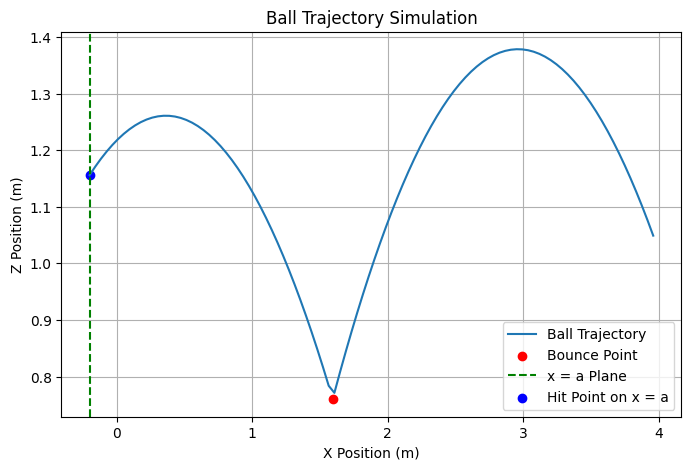

In [9]:

# Constants
g = env.gravitational_acceleration  # Gravity (m/s^2)
table_height = env.table_height  # Table tennis table height in meters
x_a = -0.2  # The 'x = a' plane where we check the hit
coeff_restitution = env.table_restitution  # Bounce efficiency (0.9 means 90% energy retained)
initial_position = np.array([3.961, 0.027, 1.049])  # Start position (x, y, z)
initial_velocity = np.array([-3.851, -0.480, 2.541])  # Initial velocity (vx, vy, vz)


bounce_position, bounce_velocity, hit_position, t_bounce, t_hit = get_bounce_position_and_hit_position(initial_position,
                                                                    initial_velocity,
                                                                    table_height,
                                                                    coeff_restitution,
                                                                    x_a,
                                                                    )

print("Predicted Bounce Position:", bounce_position)
print("Predicted Hit Position on x =", x_a, ":", hit_position)

# Plotting the trajectory
t_values = np.linspace(0, t_bounce + t_hit, num=100)
x_traj = np.concatenate([initial_position[0] + initial_velocity[0] * t_values[t_values < t_bounce],
                         bounce_position[0] + bounce_velocity[0] * (t_values[t_values >= t_bounce] - t_bounce)])
y_traj = np.concatenate([initial_position[1] + initial_velocity[1] * t_values[t_values < t_bounce],
                         bounce_position[1] + bounce_velocity[1] * (t_values[t_values >= t_bounce] - t_bounce)])
z_traj = np.concatenate([initial_position[2] + initial_velocity[2] * t_values[t_values < t_bounce] - 0.5 * g * t_values[t_values < t_bounce]**2,
                         bounce_position[2] + bounce_velocity[2] * (t_values[t_values >= t_bounce] - t_bounce) - 0.5 * g * (t_values[t_values >= t_bounce] - t_bounce)**2])

plt.figure(figsize=(8, 5))
plt.plot(x_traj, z_traj, label="Ball Trajectory")
plt.scatter([bounce_position[0]], [bounce_position[2]], color='red', label="Bounce Point")
plt.axvline(x=x_a, color='green', linestyle='--', label="x = a Plane")
plt.scatter([hit_position[0]], [hit_position[2]], color='blue', label="Hit Point on x = a")
plt.xlabel("X Position (m)")
plt.ylabel("Z Position (m)")
plt.legend()
plt.title("Ball Trajectory Simulation")
plt.grid()
plt.show()


In [12]:
# Load the trained model
# model = PPO.load("panda_tennis_model")

# Test the model
# env = PandaTennisEnv()

obs = env.reset()
env.set_ball_init_position(initial_position)
env.throw_ball(initial_velocity)
draw_xa_plane(x_a)
prev_position = p.getBasePositionAndOrientation(env.ball_id)[0]  # Initial position
for i in range(100000):
    # panda_action = [-0.066, -1.925, -0.033, -2.016, 0.099, 1.858, 1.818] # joint position
    panda_action = [0]*7 # panda_velocities
    husky_action = [0]*4 # wheel velocity
    action = panda_action + husky_action
    obs, reward, done, info = env.step(action)
    ball_real_position, _ = p.getBasePositionAndOrientation(env.ball_id)
    x, y, z = ball_real_position
    # Check if the ball crossed x = a
    if x < x_a <= prev_position[0]:  # Moving in positive x direction
        # Linear interpolation to find exact crossing point
        alpha = (x_a - prev_position[0]) / (x - prev_position[0])
        hit_y = prev_position[1] + alpha * (y - prev_position[1])
        hit_z = prev_position[2] + alpha * (z - prev_position[2])
        # Mark the hitting point
        p.addUserDebugPoints([[x_a, hit_y, hit_z]], [[0, 0, 1]], 10)  # Red dot
        print(f"Ball hit x = {x_a} at y = {hit_y:.3f}, z = {hit_z:.3f}")
        break
    prev_position = ball_real_position
    time.sleep(1/240)


KeyboardInterrupt: 

## The big Loop: data collection for residual predictor

In [14]:
g = 9.8  # Gravity (m/s^2) [We will use this instead of the actual one set in the simulator to ensure our set parameters are different than the actual ones]
table_height = env.table_height  # Table tennis table height in meters
x_a = -0.2  # The 'x = a' plane where we check the hit
coeff_restitution = 0.85 # different from the simulator. to set inaccuracy in preset parameters. 
num_experiments = 10000
draw_xa_plane(x_a)

for exp in range(num_experiments):
    # env.reset()
    # Set random initial conditions
    set_random_ball_conditions(env.ball_id)
    
    pos1 = p.getBasePositionAndOrientation(env.ball_id)[0]  # First position
    p.stepSimulation()
    time.sleep(env.time_step)  # Simulate a step
    pos2 = p.getBasePositionAndOrientation(env.ball_id)[0]  # Second position
    d = pos1[0] - x_a
    estimated_initial_velocity = estimate_initial_velocity(pos1, pos2, env.time_step)
    bounce_position, bounce_velocity, estimated_hit_position, t_bounce, t_hit = get_bounce_position_and_hit_position(pos1,
                                                                        estimated_initial_velocity,
                                                                        table_height,
                                                                        coeff_restitution,
                                                                        x_a,
                                                                        g,                                   
                                                                        )
    
    # p.addUserDebugPoints([estimated_hit_position], [[1, 0, 0]], 10)  # estimated hit point
    prev_position = p.getBasePositionAndOrientation(env.ball_id)[0]  # Initial position
    for i in range(5000):
        # panda_action = [-0.066, -1.925, -0.033, -2.016, 0.099, 1.858, 1.818] # joint position
        panda_action = [0]*7 # panda_velocities
        husky_action = [0]*4 # wheel velocity
        action = panda_action + husky_action
        obs, reward, done, info = env.step(action)
        
        ball_real_position, _ = p.getBasePositionAndOrientation(env.ball_id)
        x, y, z = ball_real_position
        # Check if the ball crossed x = a
        if x < x_a <= prev_position[0]:  # Moving in positive x direction
            # Linear interpolation to find exact crossing point
            alpha = (x_a - prev_position[0]) / (x - prev_position[0])
            hit_y = prev_position[1] + alpha * (y - prev_position[1])
            hit_z = prev_position[2] + alpha * (z - prev_position[2])
            # Mark the hitting point
            # p.addUserDebugPoints([[x_a, hit_y, hit_z]], [[0, 0, 1]], 10)  # real hit point
            # print(f"Ball hit x = {x_a} at y = {hit_y:.3f}, z = {hit_z:.3f}")
            real_hit_position = [x_a, hit_y, hit_z]
            delta = real_hit_position - estimated_hit_position
            write_to_csv(pos1, 
                        estimated_initial_velocity,
                        d,
                        estimated_hit_position,
                        real_hit_position,
                        delta,
                        )
            break
        prev_position = ball_real_position
        # time.sleep(env.time_step)

